# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64\\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

<a id="dqn"></a>
***************
#### 4-1. Definite a DQN architecture

In [1]:
%matplotlib inline
import torch
import random
import collections
import pickle
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size, build_network, lr=0.001, discount_factor=.99,
                 replay_mem_size=2500, batch_size=32, smooth_update_tau=0.001):
        
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        torch.cuda.set_device(0)
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.batch_size = batch_size
        self.tau = smooth_update_tau
        self.discount_factor = discount_factor
        self.replay_memory = collections.deque(maxlen=replay_mem_size)
        self.runner_network = build_network.cuda()
        self.target_network = build_network.cuda()

        self.runner_optimizer = torch.optim.Adam(self.runner_network.parameters(), lr=self.lr)
        
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.runner_network.state_dict())
    
    def update_target_network_smooth(self):
        # refer to https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py
        for target, runner in zip(self.target_network.parameters(), self.runner_network.parameters()):
            target.data.copy_(self.tau * runner.data + (1 - self.tau) * target.data)
    
    def optimize(self, x, y):
        loss_func = torch.nn.SmoothL1Loss() # Huber loss
        #loss_func = torch.nn.MSELoss()
        loss = loss_func(x, y)
        self.runner_optimizer.zero_grad()
        loss.backward()
        self.runner_optimizer.step()
    
    def get_action(self, state):
        return np.argmax(self.runner_network(torch.tensor(state, requires_grad=False, dtype=torch.float32)).cpu().detach().numpy())
    
    def max_q(self, state):
        return np.max(self.runner_network(torch.tensor(state, requires_grad=False, dtype=torch.float32)).cpu().detach().numpy())
        
    
    def append_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory.append([state, action, reward, next_state, done])
    
    def get_batch(self):
        batch = random.sample(self.replay_memory, self.batch_size)
        state, next_state = np.empty([self.batch_size, self.state_size*4]), np.empty([self.batch_size, self.state_size*4])
        action, reward, done = [], [], []
        
        for i in range(self.batch_size):
            state[i] = batch[i][0]
            action.append(batch[i][1])
            reward.append(batch[i][2])
            next_state[i] = batch[i][3]
            done.append(batch[i][4])
        return state, action, reward, next_state, done
    
    def train(self):
        s, a, r, s_n, d = self.get_batch()
        tensor_s = torch.tensor(s, requires_grad=False, dtype=torch.float32)
        tensor_s_n = torch.tensor(s_n, requires_grad=False, dtype=torch.float32)
        target_q = self.target_network(tensor_s_n).cpu()
        runner_q = self.runner_network(tensor_s).cpu()
        
        update_target = np.empty([self.state_size, self.action_size])
        update_target = target_q.detach().numpy()
        
        q = torch.tensor(target_q)
        for i in range(self.batch_size):
            if d[i] is True:
                update_target[i][a[i]] = r[i]
            else:
                update_target[i][a[i]] = r[i] + self.discount_factor * torch.max(target_q[i])
        

        current = torch.tensor(runner_q, requires_grad=True, dtype=torch.float32)
        target = torch.tensor(update_target, requires_grad=False, dtype=torch.float32)
        
        loss_func = torch.nn.SmoothL1Loss()
        loss = loss_func(current, target)
        self.runner_optimizer.zero_grad()
        loss.backward()
        self.runner_optimizer.step()
    
    def save_model(self, p):
        torch.save(self.runner_network.state_dict(), p)
    
    def restore_model(self, p):
        self.runner_network.load_state_dict(torch.load(p))

### 4-2. Define a network architecture

In [3]:
def network():
    act = torch.nn.ReLU
    model = torch.nn.Sequential(torch.nn.Linear(37*4, 64),
                           act(),
                           torch.nn.Linear(64, 64),
                           act(),
                           torch.nn.Linear(64, 4))
    return model

### 4-3. Build the agent

In [4]:
LEARNING_RATE = 5e-5
DISCOUNT_FACTOR = 0.99
REPLAY_MEMORY_SIZE = 15000
BATCH_SIZE = 64
EPSILON_DECAY = 0.995
TOTAL_EPISODES = 2000
OBSERVATION_STEP = 70
MODEL_UPDATE_EPISODE = 50

In [5]:
agent = DQNAgent(state_size=37, action_size=4, build_network=network(), lr=LEARNING_RATE,
                discount_factor=DISCOUNT_FACTOR, replay_mem_size=REPLAY_MEMORY_SIZE, batch_size=BATCH_SIZE)

### 4-4. Train the agent

In [6]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64\\Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]  # Refer to the code "1. Start the Environment" above.
print('[INFO] Environment initialized.')

scores = []
steps = 0
epsilon = 1
avg_reward = collections.deque(maxlen=100)
state_data = np.empty([37*4])
for e in range(TOTAL_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    if e is 0:
        state_data = np.stack([state, state, state, state]).flatten()
    score = 0
    while True:
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, 4)
        else:
            action = agent.get_action(state_data)
        env_info = env.step(int(action))[brain_name]
        next_state = env_info.vector_observations[0]
        next_state = np.append(next_state, state_data[0:-37])
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        
        agent.append_replay_memory(state_data, action, reward, next_state, done)
        
        if steps > OBSERVATION_STEP:
            agent.train()
            agent.update_target_network_smooth()

        score += reward
        state_data = next_state
        steps += 1
        
        if done:
            scores.append(score)
            avg_reward.append(score)
            break
             
    if e % 40 == 0:
        max_q = agent.max_q(state_data)
        if not e >= 100:
            print('[Step ' + str(steps).zfill(8) + '; Episode ' + str(e).zfill(6) + '] reward: ' + str(score),
                  "  max Q: " + str(max_q) +
                  "  ε= " + str(epsilon))
        else:
            print('[Step ' + str(steps).zfill(8) + '; Episode ' + str(e).zfill(6) + '] reward: ' + str(score),
                  "  max Q: " + str(max_q) +
                  "  ε= " + str(epsilon) + 
                 "  Avg. score: " + str(np.average(avg_reward)))
    
   # if e % MODEL_UPDATE_EPISODE == 0:
        #agent.update_target_network()
    
    if len(avg_reward) is 100:
        avg = np.average(avg_reward)
        if avg > 13:
            print("[INFO] Training completed. Total episode: " + str(e))
            break
    
    epsilon *= EPSILON_DECAY

with open('save\\scores.pickle', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
    f.close()

agent.save_model('save\\model')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[INFO] Environment initialized.
[Step 00000300; Episode 000000] reward: 0.0   max Q: 0.19882722  ε= 1
[Step 00012300; Episode 000040] reward: 0.0   max Q: 0.87492627  ε= 0.8183201210226743
[Step 00024300; Episode 000080] reward: 1.0   max Q: 0.9560765  ε= 0.6696478204705644
[Step 00036300; Episode 000120] reward: 0.0   max Q: 1.7106553  ε= 0.547986285490042  Avg. score: 0.66
[Step 00048300; Episode 000160] reward: 2.0   max Q: 2.240245  ε= 0.4484282034609769  Avg. score: 1.37
[Step 00060300; Episode 000200] reward: 2.0   max Q: 2.5649803  ε= 0.3669578217261671  Avg. score: 1.88
[Step 00072300; Episode 000240] reward: 2.0   max Q: 2.862121  ε= 0.30028896908517405  Avg. score: 2.35
[Step 00084300; Episode 000280] reward: 2.0   max Q: 3.490607  ε= 0.2457325055235537  Avg. score: 3.06
[Step 00096300; Episode 000320] reward: 0.0   max Q: 3.2000227  ε= 0.2010878536592394  Avg. score: 3.78
[Step 00108300; Episode 000360] reward: 6.0   max Q: 3.6739237  ε= 0.16455423674261854  Avg. score: 4.31

In [7]:
env.close()

### 4-4-2. Evaluate the model

In [5]:
agent = DQNAgent(state_size=37, action_size=4, build_network=network(), lr=LEARNING_RATE,
                discount_factor=DISCOUNT_FACTOR, replay_mem_size=REPLAY_MEMORY_SIZE, batch_size=BATCH_SIZE)
agent.restore_model('save\\model')
env = UnityEnvironment(file_name="Banana_Windows_x86_64\\Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]  # Refer to the code "1. Start the Environment" above.
print('[INFO] Environment initialized.')

state_data = np.empty(37*4)
avg_reward = collections.deque(maxlen=100)
for e in range(100):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    if e is 0:
        state_data = np.stack([state, state, state, state]).flatten()
    score = 0
    while True:
        action = agent.get_action(state_data)
        env_info = env.step(int(action))[brain_name]
        next_state = env_info.vector_observations[0]
        state_data = np.append(next_state, state_data[0:-37])
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        
        score += reward
        
        if done:
            avg_reward.append(score)
            break
             
    if e % 20 == 0:
            print('Episode ' + str(e).zfill(3) + ' reward: ' + str(score))

print("Avg(100 episode) score: " + str(np.average(avg_reward)))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[INFO] Environment initialized.
Episode 000 reward: 7.0
Episode 020 reward: 9.0
Episode 040 reward: 10.0
Episode 060 reward: 3.0
Episode 080 reward: 15.0
Avg(100 episode) score: 8.07


### 4-5. Visualising the training progress

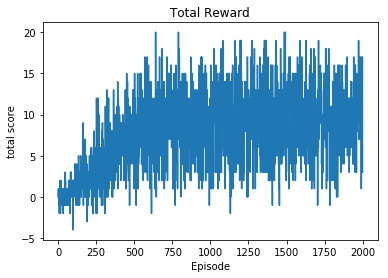

In [9]:
fig, ax = plt.subplots()
plt.plot(range(len(scores)), scores)
ax.set(xlabel='Episode', ylabel="total score")
plt.title("Total Reward")
plt.savefig("save\\reward.png", dpi=200)

## 5. Future work

- I'd like to solve this project with other reinforcement learning methods, such as Dueling DQN, Double DQN, DRQN, and so on.
- I'd like to use DQN-based network in video game invironment